### Introduction

Two classification tests on the CEGS001 L1000 dataset. We can either:
  1. Predict whether or not a patient has SCZ
  2. Predict which perturbagen was used on a sample
from the gene expression profile.

In [5]:
%load_ext autoreload
%autoreload 2

from cnn_graph import models, graph, coarsening, utils
import os, networkx, pickle, scipy, time
import numpy as np, matplotlib, matplotlib.pyplot as plt, pandas as pd, tensorflow as tf
import gene_expression_modelling.parse_cmap as pcmp
from gene_expression_modelling.constants import *
from gene_expression_modelling.utils import *
import ml_toolkit.pandas_constructions as pdc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import calibration_curve
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15, 15)
matplotlib.rcParams.update({'font.size': 22})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
def show_calibration(clfs, Xs, ys):
    plt.figure(figsize=(15, 15))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for cn, X_test, y_test in zip(clfs, Xs, ys):
        clf, name = cn
        print("Analyzing", name)
        fmt='s-'
        if hasattr(clf, "predict_proba") and 'Correl' not in name and 'Regul' not in name:
            prob_pos = clf.predict_proba(X_test)[:, 1]
        elif 'Correl' not in name and 'Regul' not in name:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        else:#if type(clf) == models.cgcnn_components:
            prob_pos = clf.class_probabilities_component(X_test)
            fmt='s--'
        
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, fmt,
                 label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

# 1 Data

We'll load the CEGS001 Dataset, and two possible graphs we can use.

In [8]:
BASE_DATA_DIR = '/scratch/mmd/project_run_files/CEGS_clustering/data'
SUPPL_DATA_DIR = '/scratch/mmd/gene_expression_modelling/gene_expression_modelling/data'
EXP_DIR = os.path.join(BASE_DATA_DIR, 'Experiment 4 (CEGS001)/')
CTRLS = [d for d in os.listdir(EXP_DIR) if '177' in d or '179' in d or '8330' in d]
SCZS = [d for d in os.listdir(EXP_DIR) if '170' in d or '215' in d]

CORR_GRAPH_FILE = os.path.join(BASE_DATA_DIR, 'gene_self_correlation.pkl')
REG_GRAPH_FILE = os.path.join(SUPPL_DATA_DIR, 'gene_regulatory_network.pkl')

HEALTHY = 0
SCZ = 1
DX_COL = 'diagnosis'

corr_graph = depickle(CORR_GRAPH_FILE)
reg_graph = depickle(REG_GRAPH_FILE)

In [9]:
def restrict_indices(df): 
    return pdc.keep_indices(df, index_levels=['cell_id', 'pert_name', 'pert_dose'],
                            column_levels=['pr_gene_symbol'])
def get_df(d):
    base = os.path.join(EXP_DIR, d, 'by_rna_well')
    path = next((d for d in os.listdir(base) if '_COMPZ.MODZ_SCORE_LM_' in d))
    return restrict_indices(pcmp.parse(os.path.join(base, path)))

In [10]:
ctrls = pd.concat([get_df(ctrl) for ctrl in CTRLS])
ctrls[DX_COL] = HEALTHY
ctrls.set_index(DX_COL, inplace=True, append=True)
sczs = pd.concat([get_df(scz) for scz in SCZS])
sczs[DX_COL] = SCZ
sczs.set_index(DX_COL, inplace=True, append=True)

X_raw = pd.concat([ctrls, sczs])
nodelist = X_raw.columns.get_level_values('pr_gene_symbol')
X_scaled = pd.DataFrame(data=scale(X_raw.values), index=X_raw.index, columns=X_raw.columns)

/scratch/mmd/.condaEnvs/gcns/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scratch/mmd/.condaEnvs/gcns/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [11]:
def get_components(G):
    all_components = [comp for comp in networkx.components.connected_component_subgraphs(G)]
    all_nodelists = [[n for n in component.nodes()] for component in all_components]
    nontrivial_components, final_nodelists, disconnected_nodes = [], [], []
    for component, nodelist in zip(all_components, all_nodelists):
        if len(nodelist) <= 10: disconnected_nodes += nodelist
        else:
            nontrivial_components.append(component)
            final_nodelists.append(nodelist)
    return nontrivial_components, final_nodelists, disconnected_nodes
    
def flatten(L): return L[0] if len(L) == 1 else L[0] + flatten(L[1:])

In [12]:
SG_corr = networkx.Graph([(u,v,d) for u,v,d in corr_graph.edges(data=True) if d['weight'] > 0.5])
SG_corr.add_nodes_from(nodelist)
corr_components, corr_nodelists, corr_disconnected_nodes = get_components(SG_corr)
total_corr_nodelist = flatten(corr_nodelists) + corr_disconnected_nodes

reg_components, reg_nodelists, reg_disconnected_nodes = get_components(reg_graph)
total_reg_nodelist = flatten(reg_nodelists) + reg_disconnected_nodes

In [13]:
X_no_graph = X_scaled.copy()
dx_y = X_no_graph.index.get_level_values(DX_COL)
drug_y = LabelEncoder().fit_transform(X_no_graph.index.get_level_values(PERT_NAME_COL))

X_corr = X_scaled[total_corr_nodelist]
X_reg  = X_scaled[total_reg_nodelist]

assert (X_no_graph.index == X_corr.index).all() and (X_no_graph.index == X_reg.index).all()

In [14]:
X_corr.columns

Index(['KDELR2', 'CDK5R1', 'SOX2', 'PSMG1', 'DECR1', 'LSM6', 'TCEAL4', 'TRAK2',
       'PCM1', 'ACBD3',
       ...
       'SLC37A4', 'PCBD1', 'BRCA1', 'IGHMBP2', 'SMC1A', 'USP6NL', 'APBB2',
       'CLPX', 'CLIC4', 'HTATSF1'],
      dtype='object', name='pr_gene_symbol', length=978)

In [15]:
X_reg.columns

Index(['TCTN1', 'MIF', 'SPAG7', 'IPO13', 'OXCT1', 'KDELR2', 'BTK', 'CPSF4',
       'IKBKB', 'EPHB2',
       ...
       'COG7', 'FGFR2', 'CHP', 'GRB7', 'ENOSF1', 'ICMT', 'CTNNAL1', 'PCBD1',
       'INPP1', 'LRPAP1'],
      dtype='object', name='pr_gene_symbol', length=978)

In [16]:
def plot_many_adj_matricies(Ms):
    N = len(Ms)
    width = int(np.ceil(np.sqrt(N)))
    
    subplot_str = lambda i: '{width}{width}{i}'.format(width=width, i=i)
    for i, M in enumerate(Ms):
        ax = plt.subplot(subplot_str(i))
        ax.spy(M, markersize=0.5, color='black')
        ax.set_title('Correlation Graph')

    plt.show()

In [17]:
BASE_PARAMS = {
    'num_epochs': 300,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.98,
    'momentum': 0.9,
    'decay_steps': 400,
}

In [18]:
def train_graph_net(
    X, y, components, nodelists, disconnected_nodes,
    levels           = 3,
    self_connections = False,
    normalized       = True,
    base_params      = BASE_PARAMS,
    update_params    = {}, 
    train            = True
):
    assert 'dir_name' in update_params and type(update_params['dir_name']) == str,\
    "dir_name must be provided (and must be a string)"
    
    X_train, X_val, X_test, y_train, y_val, y_test = pdc.split([X, y], dev_size=0.08)
    num_components = len(components)

    print("Train Shape: ", X_train.shape, y_train.shape)
    print("Dev Shape: ", X_val.shape, y_val.shape)
    print("Test Shape: ", X_test.shape, y_test.shape)
    print("Num Components: ", num_components)
    
    adjacency_matricies = [
        networkx.adjacency_matrix(c, nodelist=n).astype(np.float32) for c, n in zip(components, nodelists)
    ]
    plot_many_adj_matricies(adjacency_matricies)
    
    graphs, Ls, perms, X_trains, X_vals, X_tests = [], [], [], [], [], []
    for component, nodelist, A in zip(range(num_components), nodelists, adjacency_matricies):
        print("Analyzing component %d with %d nodes" % (component, len(nodelist)))
        gs, perm = coarsening.coarsen(A, levels=levels, self_connections=False)
        Ls.append([graph.laplacian(g, normalized=normalized) for g in gs])
        graphs.append(gs)
        perms.append(perm)
        X_trains.append(coarsening.perm_data(X_train[nodelist].copy().values, perm).astype(np.float32))
        X_vals.append(coarsening.perm_data(X_val[nodelist].copy().values, perm).astype(np.float32))
        X_tests.append(coarsening.perm_data(X_test[nodelist].copy().values, perm).astype(np.float32))
    
    X_trains.append(X_train[disconnected_nodes].values.astype(np.float32))
    X_vals.append(X_val[disconnected_nodes].values.astype(np.float32))
    X_tests.append(X_test[disconnected_nodes].values.astype(np.float32))
    
    for c in range(num_components):
        assert X_trains[c].shape[1] == X_vals[c].shape[1]
        assert X_vals[c].shape[1] == X_tests[c].shape[1]
    for df_list in [X_trains, X_vals, X_tests]:
        num_samples = df_list[0].shape[0]
        for df in df_list: assert df.shape[0] == num_samples
    
    params = base_params.copy()
    params.update(update_params)
    
    m = models.cgcnn_components(Ls=Ls, num_disconnected_nodes=len(disconnected_nodes), **params)
    if train: return m.fit_components(X_trains, y_train, X_vals, y_val), m, (X_trains, X_vals, X_tests), y_test
    else: return m, (X_trains, X_vals, X_tests), y_test

In [19]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_corr_multicomp',
#     # Architecture.
#     'Fs': [[25, 25], [25, 25]],  # Number of graph convolutional filters.
#     'Ks': [[5, 5], [5, 5]],  # Polynomial orders.
#     'ps': [[2, 2], [2, 2]],    # Pooling sizes.
#     'M': [50, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 1e-3,
#     'decay_rate': 0.96,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_corr, drug_y, corr_components, corr_nodelists, corr_disconnected_nodes,
#                      update_params=update_params)
# res[1].evaluate_component(res[2][-1], res[3])
# 47%

In [20]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_corr_multicomp',
#     # Architecture.
#     'Fs': [[30, 10, 5], [30, 10, 5]],  # Number of graph convolutional filters.
#     'Ks': [[15, 10, 2], [15, 10, 2]],  # Polynomial orders.
#     'ps': [[8, 2, 2], [8, 2, 2]],    # Pooling sizes.
#     'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 0.1,
#     'dropout': 0.5,
#     'learning_rate': 5e-4,
#     'decay_rate': 0.98,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_corr, drug_y, corr_components, corr_nodelists, corr_disconnected_nodes,
#                      update_params=update_params, levels=6)
# res[1].evaluate_component(res[2][-1], res[3])
# 32%

Train Shape:  (1393, 978) (1393,)
Dev Shape:  (122, 978) (122,)
Test Shape:  (379, 978) (379,)
Num Components:  2


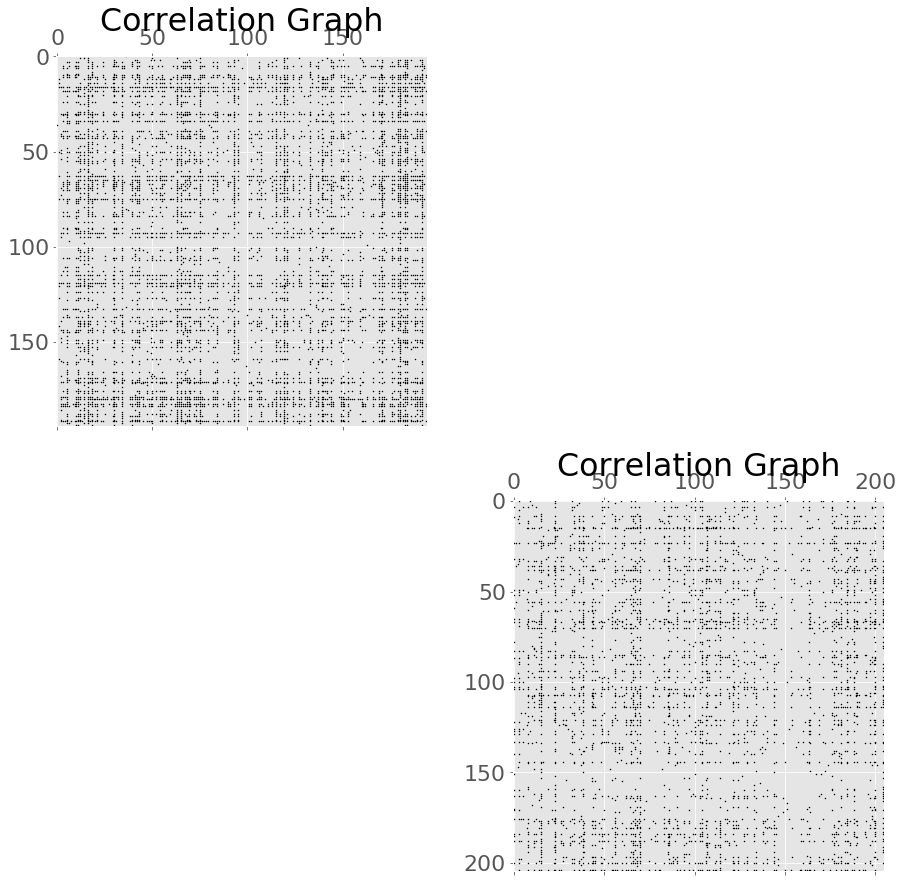

Analyzing component 0 with 205 nodes
Layer 0: M_0 = |V| = 256 nodes (51 added),|E| = 1739 edges
Layer 1: M_1 = |V| = 128 nodes (14 added),|E| = 1245 edges
Layer 2: M_2 = |V| = 64 nodes (5 added),|E| = 720 edges
Layer 3: M_3 = |V| = 32 nodes (2 added),|E| = 319 edges
Layer 4: M_4 = |V| = 16 nodes (1 added),|E| = 94 edges
Layer 5: M_5 = |V| = 8 nodes (0 added),|E| = 27 edges
Analyzing component 1 with 195 nodes
Layer 0: M_0 = |V| = 224 nodes (29 added),|E| = 2851 edges
Layer 1: M_1 = |V| = 112 nodes (3 added),|E| = 1863 edges
Layer 2: M_2 = |V| = 56 nodes (0 added),|E| = 954 edges
Layer 3: M_3 = |V| = 28 nodes (0 added),|E| = 311 edges
Layer 4: M_4 = |V| = 14 nodes (0 added),|E| = 85 edges
Layer 5: M_5 = |V| = 7 nodes (0 added),|E| = 21 edges
NN architecture for component 1
  input: M_0 = 256
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 256 * 30 / 8 = 960
    weights: F_0 * F_1 * K_1 = 1 * 30 * 15 = 450
    biases: F_1 = 30
  layer 2: cgconv2
    representation: M_1 * F_2 / p

/scratch/mmd/.condaEnvs/gcns/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mmd/.condaEnvs/gcns/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


step 100 / 20895 (epoch 1.44 / 300):
  learning_rate = 5.00e-04, loss_average = 3.79e+01
  validation accuracy: 8.20 (10 / 122), f1 (weighted): 4.82, loss: 3.64e+01
  time: 3s (wall 3s)
step 200 / 20895 (epoch 2.87 / 300):
  learning_rate = 5.00e-04, loss_average = 3.39e+01
  validation accuracy: 12.30 (15 / 122), f1 (weighted): 8.88, loss: 3.29e+01
  time: 6s (wall 5s)
step 300 / 20895 (epoch 4.31 / 300):
  learning_rate = 5.00e-04, loss_average = 3.06e+01
  validation accuracy: 15.57 (19 / 122), f1 (weighted): 9.76, loss: 2.99e+01
  time: 9s (wall 6s)
step 400 / 20895 (epoch 5.74 / 300):
  learning_rate = 5.00e-04, loss_average = 2.79e+01
  validation accuracy: 15.57 (19 / 122), f1 (weighted): 10.06, loss: 2.73e+01
  time: 11s (wall 8s)
step 500 / 20895 (epoch 7.18 / 300):
  learning_rate = 4.90e-04, loss_average = 2.54e+01
  validation accuracy: 16.39 (20 / 122), f1 (weighted): 10.96, loss: 2.50e+01
  time: 14s (wall 9s)
step 600 / 20895 (epoch 8.61 / 300):
  learning_rate = 4.90e-0

step 4400 / 20895 (epoch 63.17 / 300):
  learning_rate = 4.09e-04, loss_average = 3.96e+00
  validation accuracy: 27.05 (33 / 122), f1 (weighted): 24.27, loss: 4.16e+00
  time: 118s (wall 66s)
step 4500 / 20895 (epoch 64.61 / 300):
  learning_rate = 4.00e-04, loss_average = 3.84e+00
  validation accuracy: 27.87 (34 / 122), f1 (weighted): 25.25, loss: 4.11e+00
  time: 121s (wall 68s)
step 4600 / 20895 (epoch 66.04 / 300):
  learning_rate = 4.00e-04, loss_average = 3.84e+00
  validation accuracy: 27.05 (33 / 122), f1 (weighted): 24.28, loss: 4.05e+00
  time: 124s (wall 69s)
step 4700 / 20895 (epoch 67.48 / 300):
  learning_rate = 4.00e-04, loss_average = 3.82e+00
  validation accuracy: 27.05 (33 / 122), f1 (weighted): 24.43, loss: 4.02e+00
  time: 127s (wall 71s)
step 4800 / 20895 (epoch 68.92 / 300):
  learning_rate = 4.00e-04, loss_average = 3.76e+00
  validation accuracy: 26.23 (32 / 122), f1 (weighted): 23.90, loss: 3.97e+00
  time: 130s (wall 72s)
step 4900 / 20895 (epoch 70.35 / 30

KeyboardInterrupt: 

In [22]:
update_params = {
    'dir_name': 'gcnn_drug_classifier_corr_multicomp',
    # Architecture.
    'Fs': [[30, 10], [30, 10]],  # Number of graph convolutional filters.
    'Ks': [[15, 10], [15, 10]],  # Polynomial orders.
    'ps': [[8, 2], [8, 2]],    # Pooling sizes.
    'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 0.1,
    'dropout': 0.5,
    'learning_rate': 5e-4,
    'decay_rate': 0.98,
    'momentum': 0.9,
}
res = train_graph_net(X_corr, drug_y, corr_components, corr_nodelists, corr_disconnected_nodes,
                     update_params=update_params, levels=5)
res[1].evaluate_component(res[2][-1], res[3])

In [27]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_reg_multicomp',
#     # Architecture.
#     'Fs': [[25, 25]],  # Number of graph convolutional filters.
#     'Ks': [[5, 5]],  # Polynomial orders.
#     'ps': [[2, 2]],    # Pooling sizes.
#     'M': [50, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 1e-3,
#     'decay_rate': 0.96,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_reg, drug_y, reg_components, reg_nodelists, reg_disconnected_nodes,
#                      update_params=update_params)
# res[1].evaluate_component(res[2][-1], res[3])
# ~55%

In [36]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_reg_multicomp',
#     # Architecture.
#     'Fs': [[20, 20, 20]],  # Number of graph convolutional filters.
#     'Ks': [[10, 7, 5]],  # Polynomial orders.
#     'ps': [[2, 2, 2]],    # Pooling sizes.
#     'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 5e-4,
#     'decay_rate': 0.98,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_reg, drug_y, reg_components, reg_nodelists, reg_disconnected_nodes,
#                      update_params=update_params, levels=4)
# res[1].evaluate_component(res[2][-1], res[3])
# 57%

Train Shape:  (1393, 978) (1393,)
Dev Shape:  (122, 978) (122,)
Test Shape:  (379, 978) (379,)
Num Components:  1


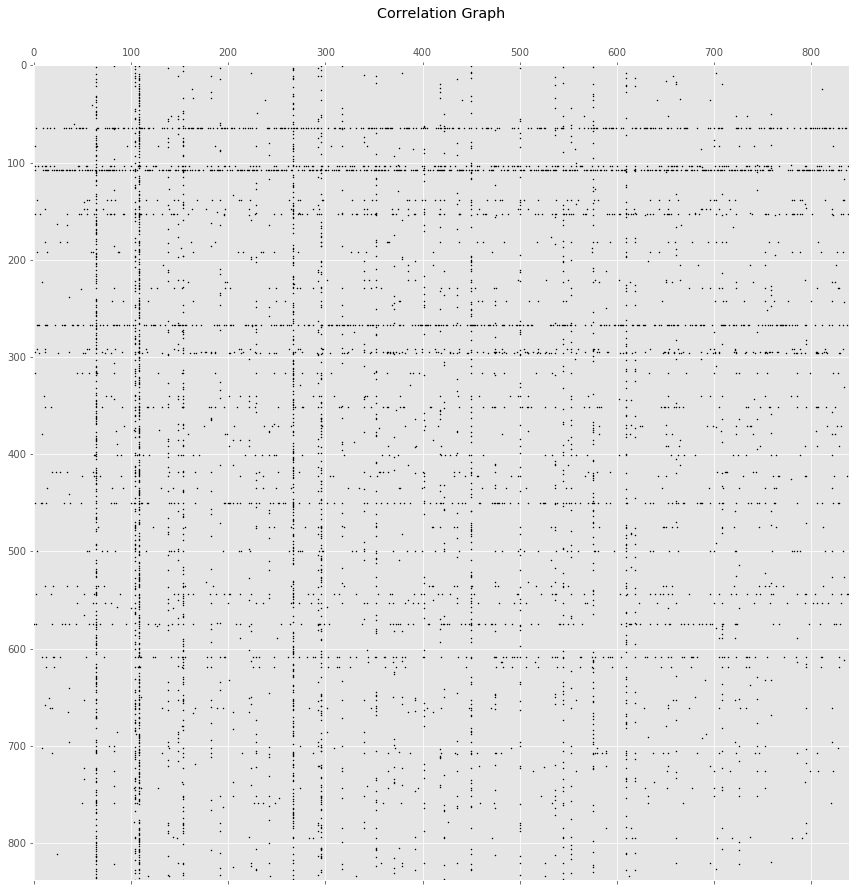

Analyzing component 0 with 839 nodes
Layer 0: M_0 = |V| = 2732 nodes (1893 added),|E| = 2748 edges
Layer 1: M_1 = |V| = 1366 nodes (614 added),|E| = 2583 edges
Layer 2: M_2 = |V| = 683 nodes (0 added),|E| = 2450 edges
NN architecture for component 1
  input: M_0 = 2732
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 2732 * 15 / 2 = 20490
    weights: F_0 * F_1 * K_1 = 1 * 15 * 7 = 105
    biases: F_1 = 15
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 20490 * 100 = 2049000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 60
    weights: M_2 * M_3 = 100 * 60 = 6000
    biases: M_3 = 60
step 100 / 20895 (epoch 1.44 / 300):
  learning_rate = 5.00e-04, loss_average = 3.88e+02
  validation accuracy: 4.10 (5 / 122), f1 (weighted): 2.59, loss: 3.80e+02
  time: 1s (wall 1s)


/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


step 200 / 20895 (epoch 2.87 / 300):
  learning_rate = 5.00e-04, loss_average = 3.69e+02
  validation accuracy: 9.84 (12 / 122), f1 (weighted): 5.76, loss: 3.61e+02
  time: 2s (wall 1s)
step 300 / 20895 (epoch 4.31 / 300):
  learning_rate = 5.00e-04, loss_average = 3.51e+02
  validation accuracy: 13.11 (16 / 122), f1 (weighted): 7.60, loss: 3.44e+02
  time: 3s (wall 2s)
step 400 / 20895 (epoch 5.74 / 300):
  learning_rate = 5.00e-04, loss_average = 3.34e+02
  validation accuracy: 14.75 (18 / 122), f1 (weighted): 9.66, loss: 3.27e+02
  time: 4s (wall 3s)
step 500 / 20895 (epoch 7.18 / 300):
  learning_rate = 4.90e-04, loss_average = 3.18e+02
  validation accuracy: 15.57 (19 / 122), f1 (weighted): 10.09, loss: 3.11e+02
  time: 6s (wall 3s)
step 600 / 20895 (epoch 8.61 / 300):
  learning_rate = 4.90e-04, loss_average = 3.03e+02
  validation accuracy: 17.21 (21 / 122), f1 (weighted): 11.49, loss: 2.97e+02
  time: 7s (wall 4s)
step 700 / 20895 (epoch 10.05 / 300):
  learning_rate = 4.90e-04

step 4500 / 20895 (epoch 64.61 / 300):
  learning_rate = 4.00e-04, loss_average = 5.48e+01
  validation accuracy: 41.80 (51 / 122), f1 (weighted): 38.98, loss: 5.41e+01
  time: 51s (wall 28s)
step 4600 / 20895 (epoch 66.04 / 300):
  learning_rate = 4.00e-04, loss_average = 5.28e+01
  validation accuracy: 44.26 (54 / 122), f1 (weighted): 41.92, loss: 5.20e+01
  time: 52s (wall 29s)
step 4700 / 20895 (epoch 67.48 / 300):
  learning_rate = 4.00e-04, loss_average = 5.07e+01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 41.76, loss: 5.01e+01
  time: 53s (wall 30s)
step 4800 / 20895 (epoch 68.92 / 300):
  learning_rate = 4.00e-04, loss_average = 4.88e+01
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 38.94, loss: 4.82e+01
  time: 55s (wall 30s)
step 4900 / 20895 (epoch 70.35 / 300):
  learning_rate = 3.92e-04, loss_average = 4.69e+01
  validation accuracy: 43.44 (53 / 122), f1 (weighted): 40.66, loss: 4.64e+01
  time: 56s (wall 31s)
step 5000 / 20895 (epoch 71.79 / 300):
 

step 8800 / 20895 (epoch 126.35 / 300):
  learning_rate = 3.27e-04, loss_average = 1.26e+01
  validation accuracy: 54.10 (66 / 122), f1 (weighted): 53.92, loss: 1.30e+01
  time: 100s (wall 56s)
step 8900 / 20895 (epoch 127.78 / 300):
  learning_rate = 3.21e-04, loss_average = 1.21e+01
  validation accuracy: 56.56 (69 / 122), f1 (weighted): 55.47, loss: 1.27e+01
  time: 101s (wall 56s)
step 9000 / 20895 (epoch 129.22 / 300):
  learning_rate = 3.21e-04, loss_average = 1.18e+01
  validation accuracy: 57.38 (70 / 122), f1 (weighted): 57.19, loss: 1.24e+01
  time: 102s (wall 57s)
step 9100 / 20895 (epoch 130.65 / 300):
  learning_rate = 3.21e-04, loss_average = 1.15e+01
  validation accuracy: 56.56 (69 / 122), f1 (weighted): 55.98, loss: 1.20e+01
  time: 104s (wall 57s)
step 9200 / 20895 (epoch 132.09 / 300):
  learning_rate = 3.21e-04, loss_average = 1.12e+01
  validation accuracy: 56.56 (69 / 122), f1 (weighted): 57.13, loss: 1.17e+01
  time: 105s (wall 58s)
step 9300 / 20895 (epoch 133.5

step 13100 / 20895 (epoch 188.08 / 300):
  learning_rate = 2.62e-04, loss_average = 4.36e+00
  validation accuracy: 58.20 (71 / 122), f1 (weighted): 57.20, loss: 5.22e+00
  time: 148s (wall 82s)
step 13200 / 20895 (epoch 189.52 / 300):
  learning_rate = 2.62e-04, loss_average = 4.25e+00
  validation accuracy: 59.84 (73 / 122), f1 (weighted): 59.06, loss: 5.15e+00
  time: 149s (wall 83s)
step 13300 / 20895 (epoch 190.95 / 300):
  learning_rate = 2.57e-04, loss_average = 4.21e+00
  validation accuracy: 60.66 (74 / 122), f1 (weighted): 60.47, loss: 5.08e+00
  time: 150s (wall 84s)
step 13400 / 20895 (epoch 192.39 / 300):
  learning_rate = 2.57e-04, loss_average = 4.13e+00
  validation accuracy: 60.66 (74 / 122), f1 (weighted): 61.68, loss: 4.98e+00
  time: 151s (wall 84s)
step 13500 / 20895 (epoch 193.83 / 300):
  learning_rate = 2.57e-04, loss_average = 4.05e+00
  validation accuracy: 62.30 (76 / 122), f1 (weighted): 62.89, loss: 4.89e+00
  time: 152s (wall 85s)
step 13600 / 20895 (epoch

step 17300 / 20895 (epoch 248.38 / 300):
  learning_rate = 2.10e-04, loss_average = 2.25e+00
  validation accuracy: 62.30 (76 / 122), f1 (weighted): 62.80, loss: 3.22e+00
  time: 195s (wall 109s)
step 17400 / 20895 (epoch 249.82 / 300):
  learning_rate = 2.10e-04, loss_average = 2.26e+00
  validation accuracy: 59.84 (73 / 122), f1 (weighted): 59.06, loss: 3.21e+00
  time: 196s (wall 109s)
step 17500 / 20895 (epoch 251.26 / 300):
  learning_rate = 2.10e-04, loss_average = 2.21e+00
  validation accuracy: 59.84 (73 / 122), f1 (weighted): 59.34, loss: 3.18e+00
  time: 197s (wall 110s)
step 17600 / 20895 (epoch 252.69 / 300):
  learning_rate = 2.10e-04, loss_average = 2.18e+00
  validation accuracy: 59.02 (72 / 122), f1 (weighted): 59.32, loss: 3.17e+00
  time: 198s (wall 111s)
step 17700 / 20895 (epoch 254.13 / 300):
  learning_rate = 2.06e-04, loss_average = 2.18e+00
  validation accuracy: 59.02 (72 / 122), f1 (weighted): 58.53, loss: 3.15e+00
  time: 199s (wall 111s)
step 17800 / 20895 (

('accuracy: 56.20 (213 / 379), f1 (weighted): 57.64, loss: 2.62e+00\ntime: 0s (wall 0s)',
 56.200527704485495,
 57.643938065103562,
 2.6163153912587029)

In [89]:
update_params = {
    'dir_name': 'gcnn_drug_classifier_reg_multicomp',
    # Architecture.
    'Fs': [[15]],  # Number of graph convolutional filters.
    'Ks': [[7]],  # Polynomial orders.
    'ps': [[2]],    # Pooling sizes.
    'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 5e-2,
    'dropout': 0.5,
    'learning_rate': 5e-4,
    'decay_rate': 0.98,
    'momentum': 0.9,
}
res = train_graph_net(X_reg, drug_y, reg_components, reg_nodelists, reg_disconnected_nodes,
                     update_params=update_params, levels=2)
res[1].evaluate_component(res[2][-1], res[3])

# DX Pred

In [ ]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_corr_multicomp',
#     # Architecture.
#     'Fs': [[25, 25], [25, 25]],  # Number of graph convolutional filters.
#     'Ks': [[5, 5], [5, 5]],  # Polynomial orders.
#     'ps': [[2, 2], [2, 2]],    # Pooling sizes.
#     'M': [50, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 1e-3,
#     'decay_rate': 0.96,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_corr, dx_y, corr_components, corr_nodelists, corr_disconnected_nodes,
#                      update_params=update_params)
# res[1].evaluate_component(res[2][-1], res[3])
# 89

In [38]:
# update_params = {
#     'dir_name': 'gcnn_dx_classifier_corr_multicomp',
#     # Architecture.
#     'Fs': [[25], [25]],  # Number of graph convolutional filters.
#     'Ks': [[7], [7]],  # Polynomial orders.
#     'ps': [[2], [2]],    # Pooling sizes.
#     'M': [100, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 1e-3,
#     'decay_rate': 0.96,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_corr, dx_y, corr_components, corr_nodelists, corr_disconnected_nodes,
#                      update_params=update_params, levels=2)
# res[1].evaluate_component(res[2][-1], res[3])
# 91.3

Train Shape:  (1393, 978) (1393,)
Dev Shape:  (122, 978) (122,)
Test Shape:  (379, 978) (379,)
Num Components:  2


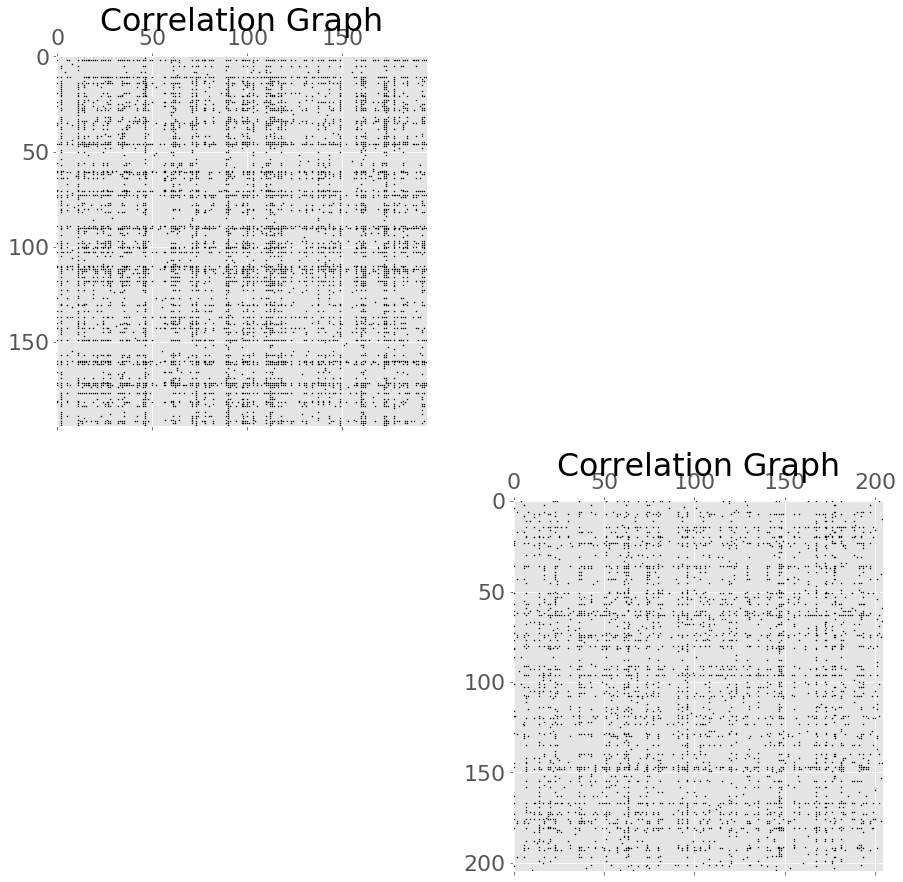

Analyzing component 0 with 205 nodes
Layer 0: M_0 = |V| = 248 nodes (43 added),|E| = 1739 edges
Layer 1: M_1 = |V| = 124 nodes (8 added),|E| = 1198 edges
Layer 2: M_2 = |V| = 62 nodes (0 added),|E| = 677 edges
Analyzing component 1 with 195 nodes
Layer 0: M_0 = |V| = 232 nodes (37 added),|E| = 2851 edges
Layer 1: M_1 = |V| = 116 nodes (5 added),|E| = 1847 edges
Layer 2: M_2 = |V| = 58 nodes (0 added),|E| = 980 edges
NN architecture for component 1
  input: M_0 = 248
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 248 * 25 / 2 = 3100
    weights: F_0 * F_1 * K_1 = 1 * 25 * 7 = 175
    biases: F_1 = 25
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 3100 * 100 = 310000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 2
    weights: M_2 * M_3 = 100 * 2 = 200
    biases: M_3 = 2
NN architecture for component 2
  input: M_0 = 232
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 232 * 25 / 2 = 2900
    weights: F_0 * F_1 * K_1

step 3800 / 20895 (epoch 54.56 / 300):
  learning_rate = 6.93e-04, loss_average = 5.37e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.61, loss: 5.39e+00
  time: 39s (wall 23s)
step 3900 / 20895 (epoch 55.99 / 300):
  learning_rate = 6.93e-04, loss_average = 5.02e+00
  validation accuracy: 90.98 (111 / 122), f1 (weighted): 90.85, loss: 5.08e+00
  time: 40s (wall 24s)
step 4000 / 20895 (epoch 57.43 / 300):
  learning_rate = 6.93e-04, loss_average = 4.72e+00
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.39, loss: 4.74e+00
  time: 41s (wall 25s)
step 4100 / 20895 (epoch 58.87 / 300):
  learning_rate = 6.65e-04, loss_average = 4.41e+00
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.42, loss: 4.49e+00
  time: 42s (wall 25s)
step 4200 / 20895 (epoch 60.30 / 300):
  learning_rate = 6.65e-04, loss_average = 4.15e+00
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.39, loss: 4.19e+00
  time: 43s (wall 26s)
step 4300 / 20895 (epoch 61.74 / 30

step 8100 / 20895 (epoch 116.30 / 300):
  learning_rate = 4.42e-04, loss_average = 6.72e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 8.30e-01
  time: 82s (wall 49s)
step 8200 / 20895 (epoch 117.73 / 300):
  learning_rate = 4.42e-04, loss_average = 6.38e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.58, loss: 8.04e-01
  time: 83s (wall 50s)
step 8300 / 20895 (epoch 119.17 / 300):
  learning_rate = 4.42e-04, loss_average = 6.23e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 7.78e-01
  time: 84s (wall 50s)
step 8400 / 20895 (epoch 120.60 / 300):
  learning_rate = 4.42e-04, loss_average = 6.11e-01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.74, loss: 7.68e-01
  time: 85s (wall 51s)
step 8500 / 20895 (epoch 122.04 / 300):
  learning_rate = 4.24e-04, loss_average = 5.86e-01
  validation accuracy: 90.98 (111 / 122), f1 (weighted): 90.97, loss: 7.66e-01
  time: 86s (wall 51s)
step 8600 / 20895 (epoch 123.4

step 12300 / 20895 (epoch 176.60 / 300):
  learning_rate = 2.94e-04, loss_average = 2.98e-01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.74, loss: 4.62e-01
  time: 123s (wall 73s)
step 12400 / 20895 (epoch 178.03 / 300):
  learning_rate = 2.94e-04, loss_average = 2.90e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 4.62e-01
  time: 124s (wall 74s)
step 12500 / 20895 (epoch 179.47 / 300):
  learning_rate = 2.82e-04, loss_average = 2.85e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 4.62e-01
  time: 125s (wall 75s)
step 12600 / 20895 (epoch 180.90 / 300):
  learning_rate = 2.82e-04, loss_average = 2.78e-01
  validation accuracy: 90.98 (111 / 122), f1 (weighted): 90.94, loss: 4.58e-01
  time: 126s (wall 75s)
step 12700 / 20895 (epoch 182.34 / 300):
  learning_rate = 2.82e-04, loss_average = 2.86e-01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.74, loss: 4.58e-01
  time: 127s (wall 76s)
step 12800 / 20895 (

step 16500 / 20895 (epoch 236.90 / 300):
  learning_rate = 1.88e-04, loss_average = 2.29e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 4.01e-01
  time: 165s (wall 99s)
step 16600 / 20895 (epoch 238.33 / 300):
  learning_rate = 1.88e-04, loss_average = 2.30e-01
  validation accuracy: 90.98 (111 / 122), f1 (weighted): 90.94, loss: 3.97e-01
  time: 166s (wall 99s)
step 16700 / 20895 (epoch 239.77 / 300):
  learning_rate = 1.88e-04, loss_average = 2.20e-01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.78, loss: 4.03e-01
  time: 167s (wall 100s)
step 16800 / 20895 (epoch 241.21 / 300):
  learning_rate = 1.88e-04, loss_average = 2.20e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 4.08e-01
  time: 168s (wall 100s)
step 16900 / 20895 (epoch 242.64 / 300):
  learning_rate = 1.80e-04, loss_average = 2.17e-01
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.39, loss: 3.99e-01
  time: 169s (wall 101s)
step 17000 / 2089

step 20700 / 20895 (epoch 297.20 / 300):
  learning_rate = 1.25e-04, loss_average = 2.03e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.55, loss: 3.79e-01
  time: 211s (wall 125s)
step 20800 / 20895 (epoch 298.64 / 300):
  learning_rate = 1.25e-04, loss_average = 2.00e-01
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.58, loss: 3.77e-01
  time: 212s (wall 125s)
step 20895 / 20895 (epoch 300.00 / 300):
  learning_rate = 1.20e-04, loss_average = 2.02e-01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.74, loss: 3.80e-01
  time: 214s (wall 126s)
validation accuracy: peak = 95.08, mean = 92.13
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_dx_classifier_corr_multicomp/model-20895


('accuracy: 91.29 (346 / 379), f1 (weighted): 91.20, loss: 3.12e-01\ntime: 0s (wall 0s)',
 91.292875989445903,
 91.199442723612819,
 0.31192350513387795)

In [70]:
update_params = {
    'dir_name': 'gcnn_dx_classifier_corr_multicomp',
    # Architecture.
    'Fs': [[25], [25]],  # Number of graph convolutional filters.
    'Ks': [[7], [7]],  # Polynomial orders.
    'ps': [[2], [2]],    # Pooling sizes.
    'M': [100, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 5e-2,
    'dropout': 0.5,
    'learning_rate': 1e-3,
    'decay_rate': 0.96,
    'momentum': 0.9,
}
res = train_graph_net(X_corr, dx_y, corr_components, corr_nodelists, corr_disconnected_nodes,
                     update_params=update_params, levels=2, train=True)
res[1].evaluate_component(res[2][-1], res[3])

In [ ]:
# update_params = {
#     'dir_name': 'gcnn_drug_classifier_reg_multicomp',
#     # Architecture.
#     'Fs': [[20, 20, 20]],  # Number of graph convolutional filters.
#     'Ks': [[10, 7, 5]],  # Polynomial orders.
#     'ps': [[2, 2, 2]],    # Pooling sizes.
#     'M': [100, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 5e-4,
#     'decay_rate': 0.98,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_reg, dx_y, reg_components, reg_nodelists, reg_disconnected_nodes,
#                      update_params=update_params, levels=4)
# res[1].evaluate_component(res[2][-1], res[3])
# 87

In [42]:
# update_params = {
#     'dir_name': 'gcnn_dx_classifier_reg_multicomp',
#     # Architecture.
#     'Fs': [[20]],  # Number of graph convolutional filters.
#     'Ks': [[10]],  # Polynomial orders.
#     'ps': [[2]],    # Pooling sizes.
#     'M': [100, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

#     # Optimization.
#     'regularization': 5e-2,
#     'dropout': 0.5,
#     'learning_rate': 5e-4,
#     'decay_rate': 0.98,
#     'momentum': 0.9,
# }
# res = train_graph_net(X_reg, dx_y, reg_components, reg_nodelists, reg_disconnected_nodes,
#                      update_params=update_params, levels=2)
# res[1].evaluate_component(res[2][-1], res[3])
# 93.4

Train Shape:  (1393, 978) (1393,)
Dev Shape:  (122, 978) (122,)
Test Shape:  (379, 978) (379,)
Num Components:  1


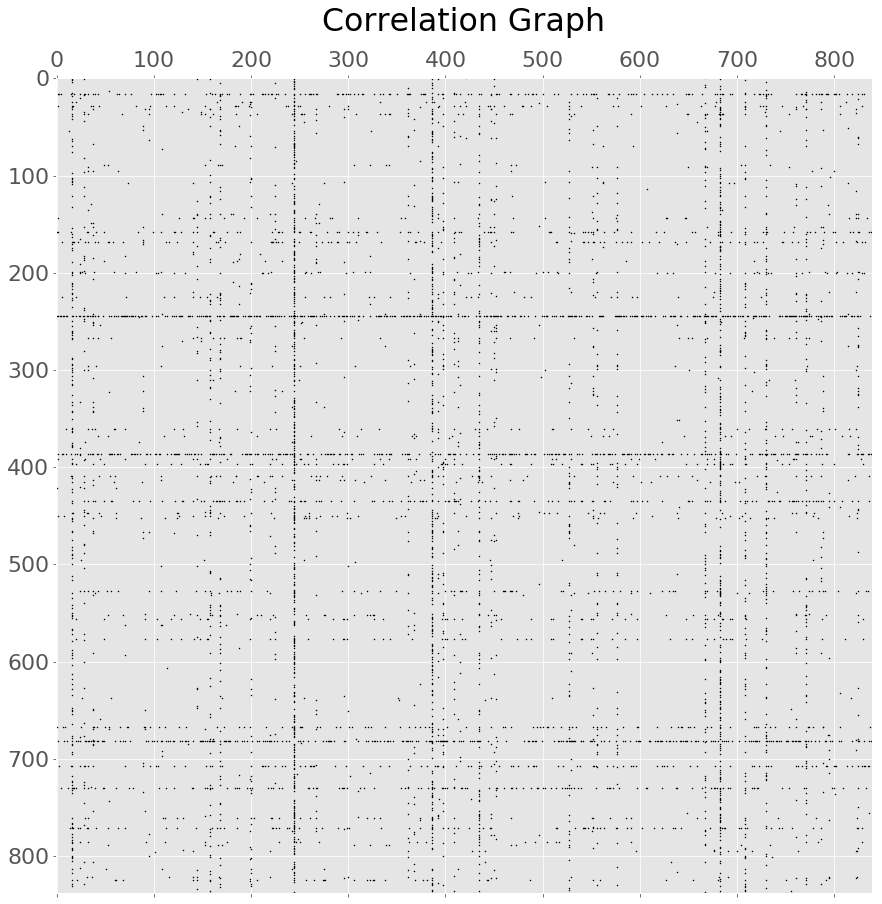

Analyzing component 0 with 839 nodes
Layer 0: M_0 = |V| = 2744 nodes (1905 added),|E| = 2748 edges
Layer 1: M_1 = |V| = 1372 nodes (618 added),|E| = 2573 edges
Layer 2: M_2 = |V| = 686 nodes (0 added),|E| = 2451 edges
NN architecture for component 1
  input: M_0 = 2744
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 2744 * 20 / 2 = 27440
    weights: F_0 * F_1 * K_1 = 1 * 20 * 10 = 200
    biases: F_1 = 20
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 27440 * 100 = 2744000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 2
    weights: M_2 * M_3 = 100 * 2 = 200
    biases: M_3 = 2
step 100 / 20895 (epoch 1.44 / 300):
  learning_rate = 5.00e-04, loss_average = 5.13e+02
  validation accuracy: 60.66 (74 / 122), f1 (weighted): 55.62, loss: 5.02e+02
  time: 1s (wall 1s)
step 200 / 20895 (epoch 2.87 / 300):
  learning_rate = 5.00e-04, loss_average = 4.88e+02
  validation accuracy: 63.93 (78 / 122), f1 (weighted): 59.32, loss: 4.77e+

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 400 / 20895 (epoch 5.74 / 300):
  learning_rate = 5.00e-04, loss_average = 4.41e+02
  validation accuracy: 63.11 (77 / 122), f1 (weighted): 56.79, loss: 4.32e+02
  time: 5s (wall 3s)
step 500 / 20895 (epoch 7.18 / 300):
  learning_rate = 4.90e-04, loss_average = 4.20e+02
  validation accuracy: 67.21 (82 / 122), f1 (weighted): 63.51, loss: 4.11e+02
  time: 7s (wall 4s)
step 600 / 20895 (epoch 8.61 / 300):
  learning_rate = 4.90e-04, loss_average = 4.00e+02
  validation accuracy: 63.11 (77 / 122), f1 (weighted): 54.39, loss: 3.91e+02
  time: 8s (wall 5s)
step 700 / 20895 (epoch 10.05 / 300):
  learning_rate = 4.90e-04, loss_average = 3.81e+02
  validation accuracy: 65.57 (80 / 122), f1 (weighted): 61.16, loss: 3.73e+02
  time: 9s (wall 5s)
step 800 / 20895 (epoch 11.49 / 300):
  learning_rate = 4.90e-04, loss_average = 3.63e+02
  validation accuracy: 66.39 (81 / 122), f1 (weighted): 61.82, loss: 3.55e+02
  time: 11s (wall 6s)
step 900 / 20895 (epoch 12.92 / 300):
  learning_rate = 4

step 4700 / 20895 (epoch 67.48 / 300):
  learning_rate = 4.00e-04, loss_average = 6.50e+01
  validation accuracy: 90.98 (111 / 122), f1 (weighted): 91.04, loss: 6.37e+01
  time: 53s (wall 39s)
step 4800 / 20895 (epoch 68.92 / 300):
  learning_rate = 4.00e-04, loss_average = 6.24e+01
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.46, loss: 6.12e+01
  time: 55s (wall 41s)
step 4900 / 20895 (epoch 70.35 / 300):
  learning_rate = 3.92e-04, loss_average = 6.00e+01
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.87, loss: 5.89e+01
  time: 56s (wall 42s)
step 5000 / 20895 (epoch 71.79 / 300):
  learning_rate = 3.92e-04, loss_average = 5.77e+01
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.48, loss: 5.66e+01
  time: 57s (wall 42s)
step 5100 / 20895 (epoch 73.22 / 300):
  learning_rate = 3.92e-04, loss_average = 5.55e+01
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.46, loss: 5.44e+01
  time: 58s (wall 43s)
step 5200 / 20895 (epoch 74.66 / 30

step 9000 / 20895 (epoch 129.22 / 300):
  learning_rate = 3.21e-04, loss_average = 1.40e+01
  validation accuracy: 94.26 (115 / 122), f1 (weighted): 94.25, loss: 1.38e+01
  time: 104s (wall 84s)
step 9100 / 20895 (epoch 130.65 / 300):
  learning_rate = 3.21e-04, loss_average = 1.36e+01
  validation accuracy: 94.26 (115 / 122), f1 (weighted): 94.25, loss: 1.34e+01
  time: 105s (wall 85s)
step 9200 / 20895 (epoch 132.09 / 300):
  learning_rate = 3.21e-04, loss_average = 1.31e+01
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.49, loss: 1.30e+01
  time: 106s (wall 86s)
step 9300 / 20895 (epoch 133.52 / 300):
  learning_rate = 3.14e-04, loss_average = 1.27e+01
  validation accuracy: 94.26 (115 / 122), f1 (weighted): 94.23, loss: 1.26e+01
  time: 107s (wall 87s)
step 9400 / 20895 (epoch 134.96 / 300):
  learning_rate = 3.14e-04, loss_average = 1.23e+01
  validation accuracy: 94.26 (115 / 122), f1 (weighted): 94.23, loss: 1.22e+01
  time: 109s (wall 88s)
step 9500 / 20895 (epoch 

step 13200 / 20895 (epoch 189.52 / 300):
  learning_rate = 2.62e-04, loss_average = 4.24e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.65, loss: 4.30e+00
  time: 152s (wall 128s)
step 13300 / 20895 (epoch 190.95 / 300):
  learning_rate = 2.57e-04, loss_average = 4.13e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.63, loss: 4.19e+00
  time: 153s (wall 129s)
step 13400 / 20895 (epoch 192.39 / 300):
  learning_rate = 2.57e-04, loss_average = 4.04e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.65, loss: 4.10e+00
  time: 155s (wall 130s)
step 13500 / 20895 (epoch 193.83 / 300):
  learning_rate = 2.57e-04, loss_average = 3.93e+00
  validation accuracy: 94.26 (115 / 122), f1 (weighted): 94.23, loss: 3.99e+00
  time: 156s (wall 131s)
step 13600 / 20895 (epoch 195.26 / 300):
  learning_rate = 2.57e-04, loss_average = 3.84e+00
  validation accuracy: 93.44 (114 / 122), f1 (weighted): 93.44, loss: 3.90e+00
  time: 157s (wall 132s)
step 13700 / 20

step 17400 / 20895 (epoch 249.82 / 300):
  learning_rate = 2.10e-04, loss_average = 1.67e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.61, loss: 1.76e+00
  time: 199s (wall 171s)
step 17500 / 20895 (epoch 251.26 / 300):
  learning_rate = 2.10e-04, loss_average = 1.62e+00
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.83, loss: 1.74e+00
  time: 201s (wall 172s)
step 17600 / 20895 (epoch 252.69 / 300):
  learning_rate = 2.10e-04, loss_average = 1.60e+00
  validation accuracy: 92.62 (113 / 122), f1 (weighted): 92.63, loss: 1.71e+00
  time: 202s (wall 173s)
step 17700 / 20895 (epoch 254.13 / 300):
  learning_rate = 2.06e-04, loss_average = 1.57e+00
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.83, loss: 1.68e+00
  time: 203s (wall 174s)
step 17800 / 20895 (epoch 255.56 / 300):
  learning_rate = 2.06e-04, loss_average = 1.55e+00
  validation accuracy: 91.80 (112 / 122), f1 (weighted): 91.84, loss: 1.65e+00
  time: 204s (wall 175s)
step 17900 / 20

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


('accuracy: 90.24 (342 / 379), f1 (weighted): 90.66, loss: 1.05e+00\ntime: 0s (wall 0s)',
 90.237467018469658,
 90.659809905594486,
 1.0467361963518691)

In [71]:
update_params = {
    'dir_name': 'gcnn_dx_classifier_reg_multicomp',
    # Architecture.
    'Fs': [[20]],  # Number of graph convolutional filters.
    'Ks': [[10]],  # Polynomial orders.
    'ps': [[2]],    # Pooling sizes.
    'M': [100, max(dx_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 5e-2,
    'dropout': 0.5,
    'learning_rate': 5e-4,
    'decay_rate': 0.98,
    'momentum': 0.9,
}
res_reg = train_graph_net(X_reg, dx_y, reg_components, reg_nodelists, reg_disconnected_nodes,
                     update_params=update_params, levels=2)
res_reg[1].evaluate_component(res_reg[2][-1], res_reg[3])

# Compare Classifiers

In [17]:
clfs, accs = [], {}

In [27]:
# Classifier Constructors
clf_constructors = [
    #('Stratified Classifier',          DummyClassifier,        {},                    ()),
    ('Majority Class Classifier',      DummyClassifier,        {'strategy': 'most_frequent'},   ()),
    ('Logistic Regressor',             LogisticRegression,     {'C': 0.1},            ()),
    ('Random Forest',                  RandomForestClassifier, {'n_estimators': 400}, ()),
    ('SKlearn Fully Connected ANN',    MLPClassifier,          {'alpha': 0.1},          ()),
    ('SKlearn Fully Connected ANN 2L', MLPClassifier,          {'alpha': 0.8, 'hidden_layer_sizes': (978, 100)}, ()),
    ('SKlearn Fully Connected ANN 3L', MLPClassifier,          {'alpha': 1.5, 'hidden_layer_sizes': (978, 978, 100)}, ()),
    ('Naive Bayes',                  GaussianNB,               {}, ()),
    ('K-neighbors',                  KNeighborsClassifier,     {'n_neighbors': 20}, ()),
#    ('Decision Tree',                DecisionTreeClassifier, {'max_depth': 5}),
#    ('Linear SVC',                   LinearSVC,              {'C': 0.5}),
#    ('RBF SVC',                      SVC,                    {'C': 0.9, 'kernel': 'rbf'}),
#    ('AdaBoost',                     AdaBoostClassifier,     {}),
]
# Discarded Classifiers:
#38% Acc. (drug) (GaussianNB(),                                               'Naive Bayes'),
#30% Acc. (drug) (KNeighborsClassifier(n_neighbors=20),                       'K-neighbors'),
#15% Acc. (drug) (DecisionTreeClassifier(max_depth=5),                        'Decision Tree'),
#43% Acc. (drug) (LinearSVC(C=0.5),                                          'Linear Support Vector Classification'),
#34% Acc. (drug) (SVC(C=0.9),                                                 'RBF Support Vector Classification'),
#12% Acc. (drug) (AdaBoostClassifier(),                                       'AdaBoost'),
#1% Acc.  (drug) (GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True), 'Gaussian Processes'),
#3% Acc.  (drug) (QuadraticDiscriminantAnalysis(),                            'Quadratic Discriminat Analysis'),

In [28]:
def build_and_train(
    X, y,
    clf_constructors=clf_constructors, clfs_to_train='ALL', old_clfs=clfs, old_accs=accs
):
    X_train, X_val, X_test, y_train, y_val, y_test = pdc.split([X, y], dev_size=0.08)

    if clfs_to_train == 'ALL': clfs_to_train = range(len(clf_constructors))
    if len(clfs_to_train) == 0: return old_clfs, {}
    
    if old_clfs == []: new_clfs = [(None, 'NULL')] * len(clf_constructors)
    else: new_clfs = old_clfs
        
    new_accs = old_accs
    for idx in clfs_to_train:
        name, fn, kwargs, posargs = clf_constructors[idx]
        clf = fn(*posargs, **kwargs)
        start = time.perf_counter()
        print('Training %s' % name)
        if type(clf) == models.cgcnn:
            acc = None
#             if 'Regulatory' in name:
#                 acc = clf.fit(X_train_reg, y_train, X_val_reg, y_val)
#             elif 'Correlation' in name:
#                 acc = clf.fit(X_train_corr, y_train, X_val_corr, y_val)
#             else:
            acc = clf.fit(X_train.values, y_train, X_val.values, y_val)
            new_accs[name] = acc
        else:
            clf.fit(X_train, y_train)
        print('%s trained! Took %s' % (name, str(time.perf_counter() - start)))
        
        if idx == len(new_clfs): new_clfs.append((clf, name))
        else: new_clfs[idx] = (clf, name)
        
    return new_clfs, new_accs, (X_train, X_val, X_test), (y_train, y_val, y_test)

In [29]:
def evaluate(clfs, accs, Xs, ys):
    X_test = Xs[-1]
    y_test = ys[-1]
    for clf, name in clfs:
        print(name)
        if type(clf) != models.cgcnn:
            print('Accuracy: %.2f %%' % (100.0*clf.score(X_test, y_test)))
            try:
                scores = clf.predict_proba(X_test)
                roc_auc = roc_auc_score(y_test, scores[:,1])
                print('AUC: %.2f ' % roc_auc)
            except: continue
        elif 'Correlational' in name:
            res = clf.evaluate(X_test_corr, y_test)
            print('%.2f %%' % res[1])
        elif 'Regulatory' in name:
            res = clf.evaluate(X_test_reg, y_test)
            print('%.2f %%' % res[1])
    if max(y_test) == 1: show_calibration(clfs, X_test, y_test)

In [91]:
def evaluate_2(clfs, accs, Xs, ys):
    for cn, X_test, y_test in zip(clfs, Xs, ys):
        clf, name = cn
        print(name, type(clf))
        if type(clf) != models.cgcnn_components and 'Correlative' not in name and 'Regulatory' not in name:
            print('Accuracy: %.2f %%' % (100.0*clf.score(X_test, y_test)))
            try:
                scores = clf.predict_proba(X_test)
                roc_auc = roc_auc_score(y_test, scores[:,1])
                print('AUC: %.2f ' % roc_auc)
            except: continue
        else:
            res = clf.evaluate_component(X_test, y_test)
            print('%.2f %%' % res[1])
            #try:
            scores = clf.class_probabilities_component(X_test)
            print(scores.shape)
            roc_auc = roc_auc_score(y_test, scores)
            print('AUC: %.2f ' % roc_auc)
            #except: continue
    if max(y_test) == 1: show_calibration(clfs, Xs, ys)

In [30]:
drug_clfs, drug_accs, drug_Xs, drug_ys = build_and_train(X_no_graph, drug_y, clfs_to_train='ALL', old_clfs=[])

Training Majority Class Classifier
Majority Class Classifier trained! Took 0.0006255246698856354
Training Logistic Regressor
Logistic Regressor trained! Took 34.93997745215893
Training Random Forest
Random Forest trained! Took 32.42638934031129
Training SKlearn Fully Connected ANN


/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


SKlearn Fully Connected ANN trained! Took 9.169098637998104
Training SKlearn Fully Connected ANN 2L
SKlearn Fully Connected ANN 2L trained! Took 19.82171631604433
Training SKlearn Fully Connected ANN 3L
SKlearn Fully Connected ANN 3L trained! Took 31.083431385457516
Training Naive Bayes
Naive Bayes trained! Took 0.024870947003364563
Training K-neighbors
K-neighbors trained! Took 0.0629865862429142


In [31]:
dx_clfs, dx_accs, dx_Xs, dx_ys = build_and_train(X_no_graph, dx_y, clfs_to_train='ALL', old_clfs=[])

Training Majority Class Classifier
Majority Class Classifier trained! Took 0.00047525763511657715
Training Logistic Regressor
Logistic Regressor trained! Took 0.6513320989906788
Training Random Forest
Random Forest trained! Took 9.263110872358084
Training SKlearn Fully Connected ANN
SKlearn Fully Connected ANN trained! Took 7.872753206640482
Training SKlearn Fully Connected ANN 2L
SKlearn Fully Connected ANN 2L trained! Took 15.057017840445042
Training SKlearn Fully Connected ANN 3L
SKlearn Fully Connected ANN 3L trained! Took 24.272619895637035
Training Naive Bayes
Naive Bayes trained! Took 0.018737610429525375
Training K-neighbors
K-neighbors trained! Took 0.057508550584316254


In [32]:
evaluate(drug_clfs, drug_accs, drug_Xs, drug_ys)

Majority Class Classifier
Accuracy: 8.44 %
Logistic Regressor
Accuracy: 49.34 %
Random Forest
Accuracy: 44.59 %
SKlearn Fully Connected ANN
Accuracy: 51.19 %
SKlearn Fully Connected ANN 2L
Accuracy: 51.45 %
SKlearn Fully Connected ANN 3L
Accuracy: 44.85 %
Naive Bayes
Accuracy: 34.56 %
K-neighbors
Accuracy: 36.68 %


In [73]:
dx_clfs_2 = dx_clfs + [(res[1], 'Correlative Graph CNN'), (res_reg[1], 'Regulatory Graph CNN')]
dx_Xs_2 = [dx_Xs[-1]]*len(dx_clfs) + [res[2][-1], res_reg[2][-1]]
dx_ys_2 = [dx_ys[-1]]*len(dx_clfs) + [res[-1], res_reg[-1]]

In [62]:
type(dx_clfs_2[-1][0])

lib.models.cgcnn_components

Majority Class Classifier <class 'sklearn.dummy.DummyClassifier'>
Accuracy: 59.89 %
AUC: 0.50 
Logistic Regressor <class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: 92.08 %
AUC: 0.98 
Random Forest <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy: 92.88 %
AUC: 1.00 
SKlearn Fully Connected ANN <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Accuracy: 95.51 %
AUC: 0.99 
SKlearn Fully Connected ANN 2L <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Accuracy: 88.65 %
AUC: 0.96 
SKlearn Fully Connected ANN 3L <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Accuracy: 90.24 %
AUC: 0.94 
Naive Bayes <class 'sklearn.naive_bayes.GaussianNB'>
Accuracy: 41.42 %
AUC: 0.51 
K-neighbors <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Accuracy: 81.27 %
AUC: 0.89 
Correlative Graph CNN <class 'lib.models.cgcnn_components'>
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/li

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(379,)
AUC: 0.95 
Regulatory Graph CNN <class 'lib.models.cgcnn_components'>
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_dx_classifier_reg_multicomp/model-20895
91.03 %
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_dx_classifier_reg_multicomp/model-20895
(379,)
AUC: 0.94 
Analyzing Majority Class Classifier
Analyzing Logistic Regressor
Analyzing Random Forest
Analyzing SKlearn Fully Connected ANN
Analyzing SKlearn Fully Connected ANN 2L
Analyzing SKlearn Fully Connected ANN 3L
Analyzing Naive Bayes
Analyzing K-neighbors
Analyzing Correlative Graph CNN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_dx_classifier_corr_multicomp/model-20895
Analyzing Regulatory Graph CNN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_dx_classifier_reg_multicomp/model-20895


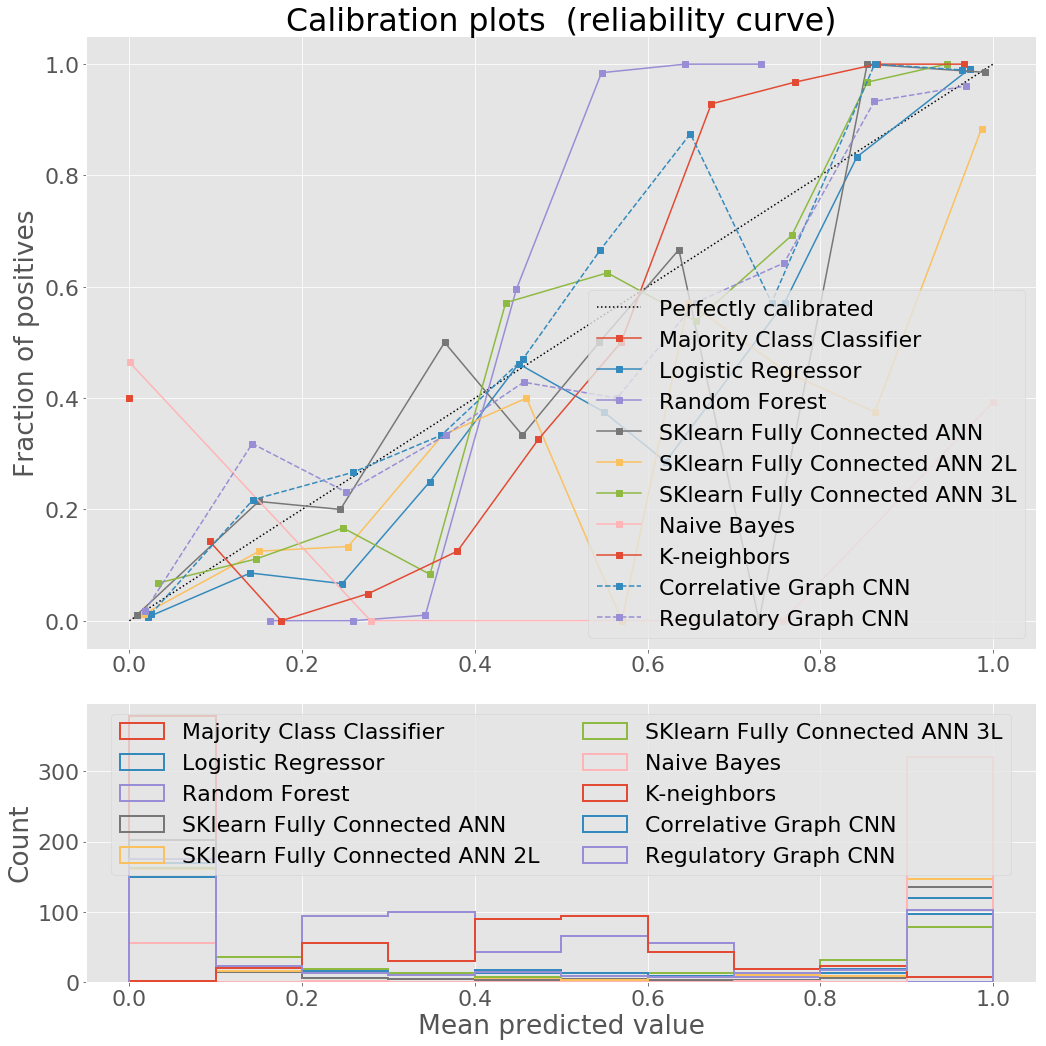

In [94]:
evaluate_2(dx_clfs_2, dx_accs, dx_Xs_2, dx_ys_2)

Majority Class Classifier
Accuracy: 59.89 %
AUC: 0.50 
Logistic Regressor
Accuracy: 92.08 %
AUC: 0.98 
Random Forest
Accuracy: 92.88 %
AUC: 1.00 
SKlearn Fully Connected ANN
Accuracy: 95.51 %
AUC: 0.99 
SKlearn Fully Connected ANN 2L
Accuracy: 88.65 %
AUC: 0.96 
SKlearn Fully Connected ANN 3L
Accuracy: 90.24 %
AUC: 0.94 
Naive Bayes
Accuracy: 41.42 %
AUC: 0.51 
K-neighbors
Accuracy: 81.27 %
AUC: 0.89 


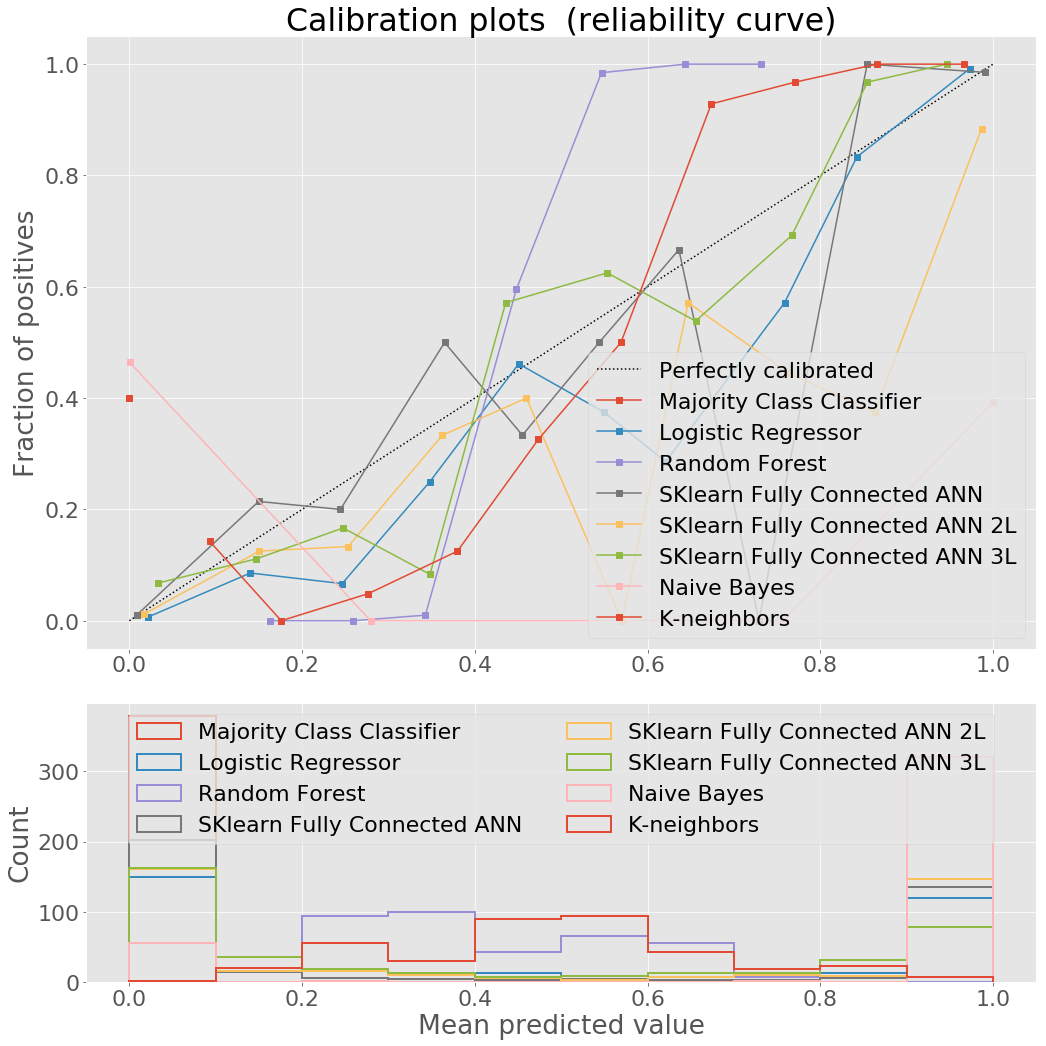

In [35]:
evaluate(dx_clfs, dx_accs, dx_Xs, dx_ys)

# 4 Evaluation


The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

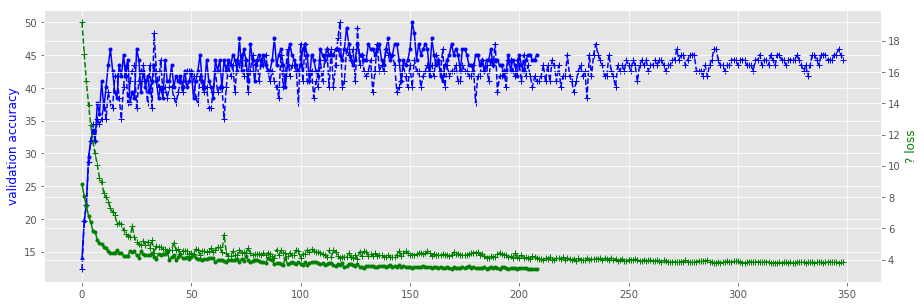

In [62]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accs['Correlational Graph Conv ANN'][0], 'b.-')
ax1.plot(accs['Regulatory Graph Conv ANN'][0], 'b+--')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(accs['Correlational Graph Conv ANN'][1], 'g.-')
ax2.plot(accs['Regulatory Graph Conv ANN'][1], 'g+--')
ax2.set_ylabel('? loss', color='g')
plt.show()